## Modelling Corn Plant Disease Classification with EfficientNet
# Summary & How to Use

The use of this web utlity platform is to let users of the internet upload pictures of corn plant images, have it be classified and get a determination output as to what kind of disease it shows. The platform will be UI/UX friendly for everyone of age, showing relevancy of informations about the indicated diseases. It is an integrated system of web development and AI modelling.

In [1]:
%%bash

python3 -m venv --system-site-packages ./venv

In [2]:
%%bash

source ./venv/bin/activate
pip install --upgrade pip
pip list

Package                      Version
---------------------------- --------------------
absl-py                      1.0.0
anyio                        3.4.0
AnyQt                        0.0.13
appdirs                      1.4.3
apturl                       0.5.2
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asn1crypto                   0.24.0
astunparse                   1.6.3
attrs                        21.4.0
backcall                     0.1.0
baycomp                      1.0.2
bcrypt                       3.1.7
beautifulsoup4               4.10.0
bleach                       4.1.0
blinker                      1.4
Bottleneck                   1.3.2
Brlapi                       0.7.0
CacheControl                 0.12.10
cachetools                   5.0.0
certifi                      2019.11.28
cffi                         1.15.0
chardet                      3.0.4
charset-normalizer           2.0.9
chrome-gnome-shell           0.0.0
Click                     

In [ ]:
 
%pip install --upgrade -q Pillow
%pip install -q tensorflow
%pip install -q keras
%pip install -q split-folders

In [4]:
import os
import sys
import keras
import numpy as np
import splitfolders
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



In [3]:
base_path = "./data"
data_dir = base_path + "/corn"
train_dir = base_path + "/train"
test_dir = base_path + "/test"
valid_dir = base_path + "/val"
diseases = os.listdir(data_dir)

# the ratio to split the data which goes into 60% training, 20% validation, 20% test
splitfolders.ratio(data_dir, base_path, seed=1337, ratio=(0.6, 0.2, 0.2), group_prefix=None)

print(diseases)
print("\nTotal disease classes are: {}".format(len(diseases)))


['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']

Total disease classes are: 4


### Exploring the Data

In [4]:
# Exploring the data gathered
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(data_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])
print(img_per_class)

n_train = 0
for val in nums.values():
    n_train += val
print(f"\nThere are {n_train} images in total for training")

                                                    No. of images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot            513
Corn_(maize)___Common_rust_                                  1192
Corn_(maize)___Northern_Leaf_Blight                           985
Corn_(maize)___healthy                                       1162

There are 3852 images in total for training


Text(0.5, 1.0, 'Images per each class of plant disease')

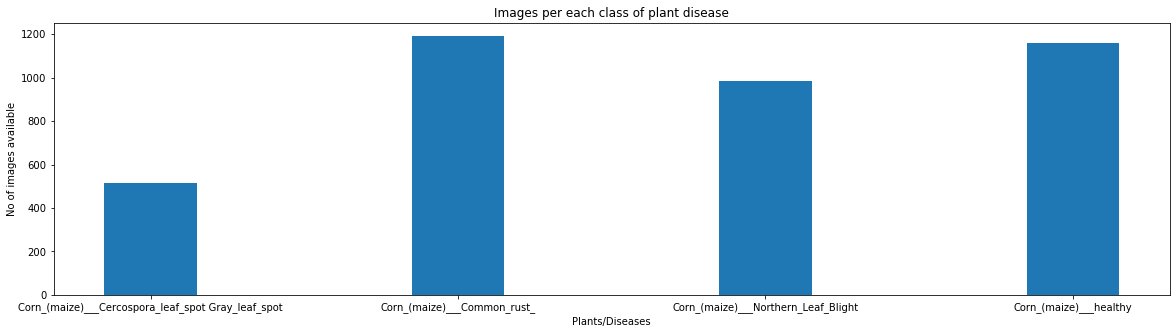

In [5]:
index = [n for n in range(4)]
plt.figure(figsize=(20,5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases')
plt.ylabel('No of images available')
plt.xticks(index, diseases)
plt.title('Images per each class of plant disease')

### Preparing the Data for Training

In any machine learning project, it is critical to set up a trustworthy validation scheme, in order to properly evaluate and compare models. This is especially true if the dataset is small which is the case of this project. For a typical image classification problem, the standard approach is to take a deep CNN model (such as the most popular EffcientNet) trained on ImageNet, replace the last layer so that the output dimension equals the target's dimension, and fine tune it on the specific dataset.

In [6]:
batch_size = 32
img_height = 180
img_width = 180

# Standardizing the data
train_gen = ImageDataGenerator(rescale=1/255.0, validation_split=0, fill_mode="nearest", rotation_range=40, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.0, validation_split=0)
test_gen = ImageDataGenerator(rescale=1/255.0)

train_gen
valid_gen
test_gen

train_data = train_gen.flow_from_directory(directory=train_dir, target_size=(260, 260), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

valid_data = valid_gen.flow_from_directory(directory=valid_dir, target_size=(260, 260), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

test_data = test_gen.flow_from_directory(directory=test_dir, target_size=(260, 260), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

# Pulling out images and labels from sets for visualization
train_imgs, train_labels = next(train_data)
valid_imgs, valid_labels = next(valid_data)
test_imgs, test_labels = next(test_data)

# print(train_data.class_indices)
# for data_batch, labels_batch in train_data:
#     print("Train Data Shape: ", data_batch.shape)
#     print("Train Label Shape: ", labels_batch.shape)

Found 2310 images belonging to 4 classes.
Found 769 images belonging to 4 classes.
Found 773 images belonging to 4 classes.


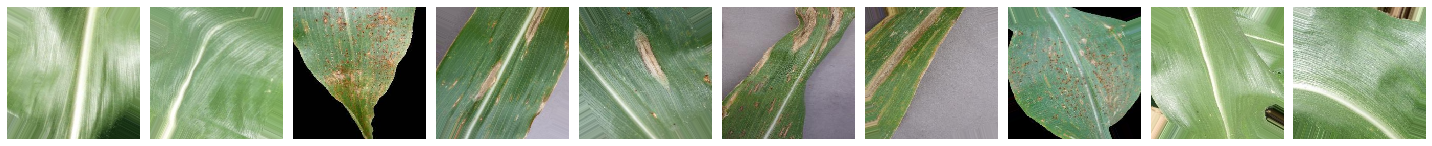

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(train_imgs[:10], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
effinet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(260,260,3))
effinet_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 260, 260, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 260, 260, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                     

In [5]:
effinet_layer = Sequential()
effinet_layer.add(effinet_model)
effinet_layer.add(layers.Flatten())
effinet_layer.add(layers.Dense(4, activation='softmax', name='Predictions'))

for layer in effinet_model.layers:
    layer.trainable = False

effinet_layer.summary()

2022-03-31 20:35:16.551893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-31 20:35:16.551958: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-31 20:35:16.551992: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x250): /proc/driver/nvidia/version does not exist
2022-03-31 20:35:16.553364: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'effinet_model' is not defined